## Raw text to word embeddings

### Preprocessing the labels of the raw imdb data

In [1]:
import os
imdb_dir = 'D:/Projects/keras/Deep Learning for text/aclImdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [2]:
labels = []
texts = []

In [3]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [1]:
# texts[100]

## Tokenizing the text of raw IMDB data

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100                     # cut off reviews after 100 words
training_samples = 16472         # train on 16472 samples
validation_samples = 10000       # validate on 10000 samples
max_words = 10000                # consider only top 10000 words from the dataset


Using TensorFlow backend.


In [5]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [6]:
print(sequences[0])

[62, 4, 3, 129, 34, 44, 7576, 1414, 15, 3, 4252, 514, 43, 16, 3, 633, 133, 12, 6, 3, 1301, 459, 4, 1751, 209, 3, 7693, 308, 6, 676, 80, 32, 2137, 1110, 3008, 31, 1, 929, 4, 42, 5120, 469, 9, 2665, 1751, 1, 223, 55, 16, 54, 828, 1318, 847, 228, 9, 40, 96, 122, 1484, 57, 145, 36, 1, 996, 141, 27, 676, 122, 1, 411, 59, 94, 2278, 303, 772, 5, 3, 837, 20, 3, 1755, 646, 42, 125, 71, 22, 235, 101, 16, 46, 49, 624, 31, 702, 84, 702, 378, 3493, 2, 8422, 67, 27, 107, 3348]


In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens.'%len(word_index))

Found 88582 unique tokens.


In [8]:
# display first 10 elements 
for x in list(word_index)[0:10]:
    print('key->',x, 'value ->', word_index[x])

key-> the value -> 1
key-> and value -> 2
key-> a value -> 3
key-> of value -> 4
key-> to value -> 5
key-> is value -> 6
key-> br value -> 7
key-> in value -> 8
key-> it value -> 9
key-> i value -> 10


In [9]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensors:', data.shape)
print('Shape of label tensors:', labels.shape)


Shape of data tensors: (25000, 100)
Shape of label tensors: (25000,)


In [10]:
indices = np.arange(data.shape[0]) #shuffle the data before splitting into train and test
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [11]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

## Use stanford's pretrained Glove word embeddings

### Parse the Glove word embeddings file to build an index that maps words to thier vector representation

In [14]:
glove_dir = 'D:/Projects/keras/Deep Learning for text/Glove/'

display = 1
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    if display == 0:
        print('line->', line)
    values = line.split()
    if display == 0:
        print('values->', values)
    word = values[0]
    if display == 0:
        print('word ->', word)
    coefs = np.asarray(values[1:], dtype='float32')
    if display == 0:
        print('coefs->', coefs)
    embedding_index[word] = coefs
f.close()

In [15]:
print('Found %s word vectors.' %len(embedding_index))

Found 400000 word vectors.


### Preparing the Glove word embeddings matrix
- Next we will build an embedding matrix that we can load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim - dimensional vector for the word of index i in the reference word index(built during tokenization). Note that index 0 is'nt supposed to stand for any word or token -it's a placeholder



In [16]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Defining a Model

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
import matplotlib.pyplot as plt

In [18]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0603 22:34:28.231143 10096 deprecation_wrapper.py:119] From C:\Users\Shubham\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0603 22:34:28.297127 10096 deprecation_wrapper.py:119] From C:\Users\Shubham\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0603 22:34:28.317529 10096 deprecation_wrapper.py:119] From C:\Users\Shubham\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


## Loading the pretrained Glove word embedding into the Embedding Layer

In [19]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

W0603 22:34:35.210122 10096 deprecation_wrapper.py:119] From C:\Users\Shubham\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:168: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0603 22:34:35.212117 10096 deprecation_wrapper.py:119] From C:\Users\Shubham\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:175: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



## Traning and evalauating the model

- Compile and train the model

In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

W0603 22:34:52.774137 10096 deprecation_wrapper.py:119] From C:\Users\Shubham\Anaconda3\lib\site-packages\keras\optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0603 22:34:52.793086 10096 deprecation.py:323] From C:\Users\Shubham\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16472 samples, validate on 8528 samples
Epoch 1/10
16472/16472 [==============================] - 3s 181us/step - loss: 0.6458 - acc: 0.6380 - val_loss: 0.6477 - val_acc: 0.6363
Epoch 2/10
16472/16472 [==============================] - 2s 123us/step - loss: 0.5198 - acc: 0.7424 - val_loss: 0.5517 - val_acc: 0.7168
Epoch 3/10
16472/16472 [==============================] - 2s 140us/step - loss: 0.4523 - acc: 0.7901 - val_loss: 0.8606 - val_acc: 0.6256
Epoch 4/10
16472/16472 [==============================] - 2s 127us/step - loss: 0.4004 - acc: 0.8130 - val_loss: 0.6058 - val_acc: 0.7101
Epoch 5/10
16472/16472 [==============================] - 2s 127us/step - loss: 0.3545 - acc: 0.8422 - val_loss: 0.6028 - val_acc: 0.7119
Epoch 6/10
16472/16472 [==============================] - 2s 149us/step - loss: 0.3005 - acc: 0.8674 - val_loss: 0.6498 - val_acc: 0.7119
Epoch 7/10
16472/16472 [==============================] - 2s 126us/step - loss: 0.2560 - acc: 0.8932 - val_loss: 0.8198 - v

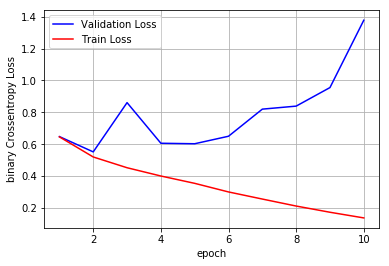

In [21]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,10+1))
# x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### Tokenizing the data of the test set

In [22]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

## Load and evaluate the model on test set

In [23]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 40us/step


[2.290133509106636, 0.51056]